## Import

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display
import os
import numpy as np
import sys 
sys.path.append('../../modules')
import data
import eval
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import dummy
from sklearn import compose
from sklearn import multioutput
from sklearn import linear_model
from sklearn import ensemble
from sklearn import feature_selection
from sklearn import model_selection

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



## Load Data

In [2]:
values = data.load_migration_rates_from_csv()
trends = data.load_trends_from_csv()
countries = data.get_countries()
keyword_ids = trends.columns.levels[0].tolist()


# panel = pd.concat([values, trends], axis='columns')
panel = values.join(trends, how="outer")
#panel


## Models

### LR - KW 19 only

In [46]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[1, 2, 3, 4], columns=["19"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(linear_model.LinearRegression())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'linearregression__fit_intercept': False, 'linearregression__positive': True}

Aggregate CV score:


,mean,std,sem
fit_time,0.002,1.041e-03,4.250e-04
score_time,0.003,5.416e-04,2.211e-04
test_mae,-0.109,3.698e-02,1.510e-02
test_rmse,-0.163,6.115e-02,2.497e-02
test_explained_variance,0.049,1.910e-01,7.796e-02
test_r2_mod,0.134,1.461e-01,5.965e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.005,0.004,-0.172,-0.248,0.116,0.314
1,0.002,0.003,-0.113,-0.185,-0.119,0.045
2,0.002,0.003,-0.129,-0.213,0.147,0.108
3,0.002,0.003,-0.074,-0.101,0.248,0.225
4,0.002,0.004,-0.089,-0.120,0.152,0.208
5,0.002,0.002,-0.079,-0.110,-0.251,-0.094


Holdout score:


mae                  -0.124
rmse                 -0.295
explained_variance    0.024
r2_mod                0.040
dtype: float64

### LR - KW 19 + AR

In [90]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[1, 2, 3, 4], columns=["19", "value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(linear_model.LinearRegression())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'linearregression__fit_intercept': False, 'linearregression__positive': True}

Aggregate CV score:


,mean,std,sem
fit_time,0.004,9.850e-04,4.021e-04
score_time,0.007,3.829e-03,1.563e-03
test_mae,-0.079,1.421e-02,5.801e-03
test_rmse,-0.116,2.449e-02,1.000e-02
test_explained_variance,0.401,2.494e-01,1.018e-01
test_r2_mod,0.478,2.533e-01,1.034e-01


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.005,0.014,-0.098,-0.140,0.606,0.781
1,0.004,0.007,-0.078,-0.138,0.364,0.470
2,0.003,0.007,-0.079,-0.122,0.679,0.709
3,0.003,0.003,-0.060,-0.078,0.537,0.537
4,0.002,0.003,-0.092,-0.122,0.155,0.188
5,0.004,0.005,-0.069,-0.095,0.067,0.182


Holdout score:


mae                  -0.126
rmse                 -0.370
explained_variance   -0.582
r2_mod               -0.512
dtype: float64

#### cv performance plot

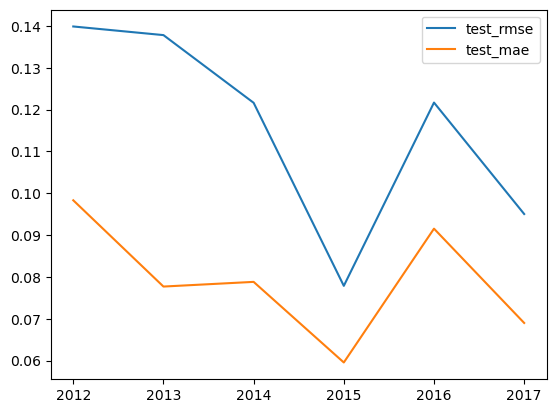

In [91]:
cv_score["test_rmse"].apply(lambda x: -x).plot()
cv_score["test_mae"].apply(lambda x: -x).plot()
# cv_score["test_r2_mod"].plot()
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5], [2012, 2013, 2014, 2015, 2016, 2017])
plt.show()

# save for comparison later
cv_score_with_trends = cv_score

#### feature importance

In [50]:
# features_names_out = reg.steps[0][1].get_feature_names_out(
#     reg.steps[0][1].get_feature_names_out()
# )
features_names_out = x_train_stacked.columns
pd.Series(reg.steps[0][1].coef_, index=features_names_out).sort_values(
    ascending=False
)

value_1    0.674
value_2    0.043
19_3       0.033
19_1       0.024
19_2       0.008
19_4       0.000
value_3    0.000
value_4    0.000
dtype: float64

#### predict

In [51]:
# y predicted over test set
pred_arr_test = reg.predict(x_test_stacked)
y_pred_stacked_test = pd.Series(pred_arr_test, index=x_test_stacked.index)
y_pred_trans_test = y_pred_stacked_test.unstack()

# y predicted over cv
pred_arr_cv = model_selection.cross_val_predict(reg, x_train_stacked, y_train_stacked, cv=cv)
y_pred_stacked_cv = pd.Series(pred_arr_cv, index=x_train_stacked.index)
y_pred_trans_cv = y_pred_stacked_cv.unstack()

y_pred_all = pd.concat([y_pred_trans_cv, y_pred_trans_test])


#### plot prediction (transformed)

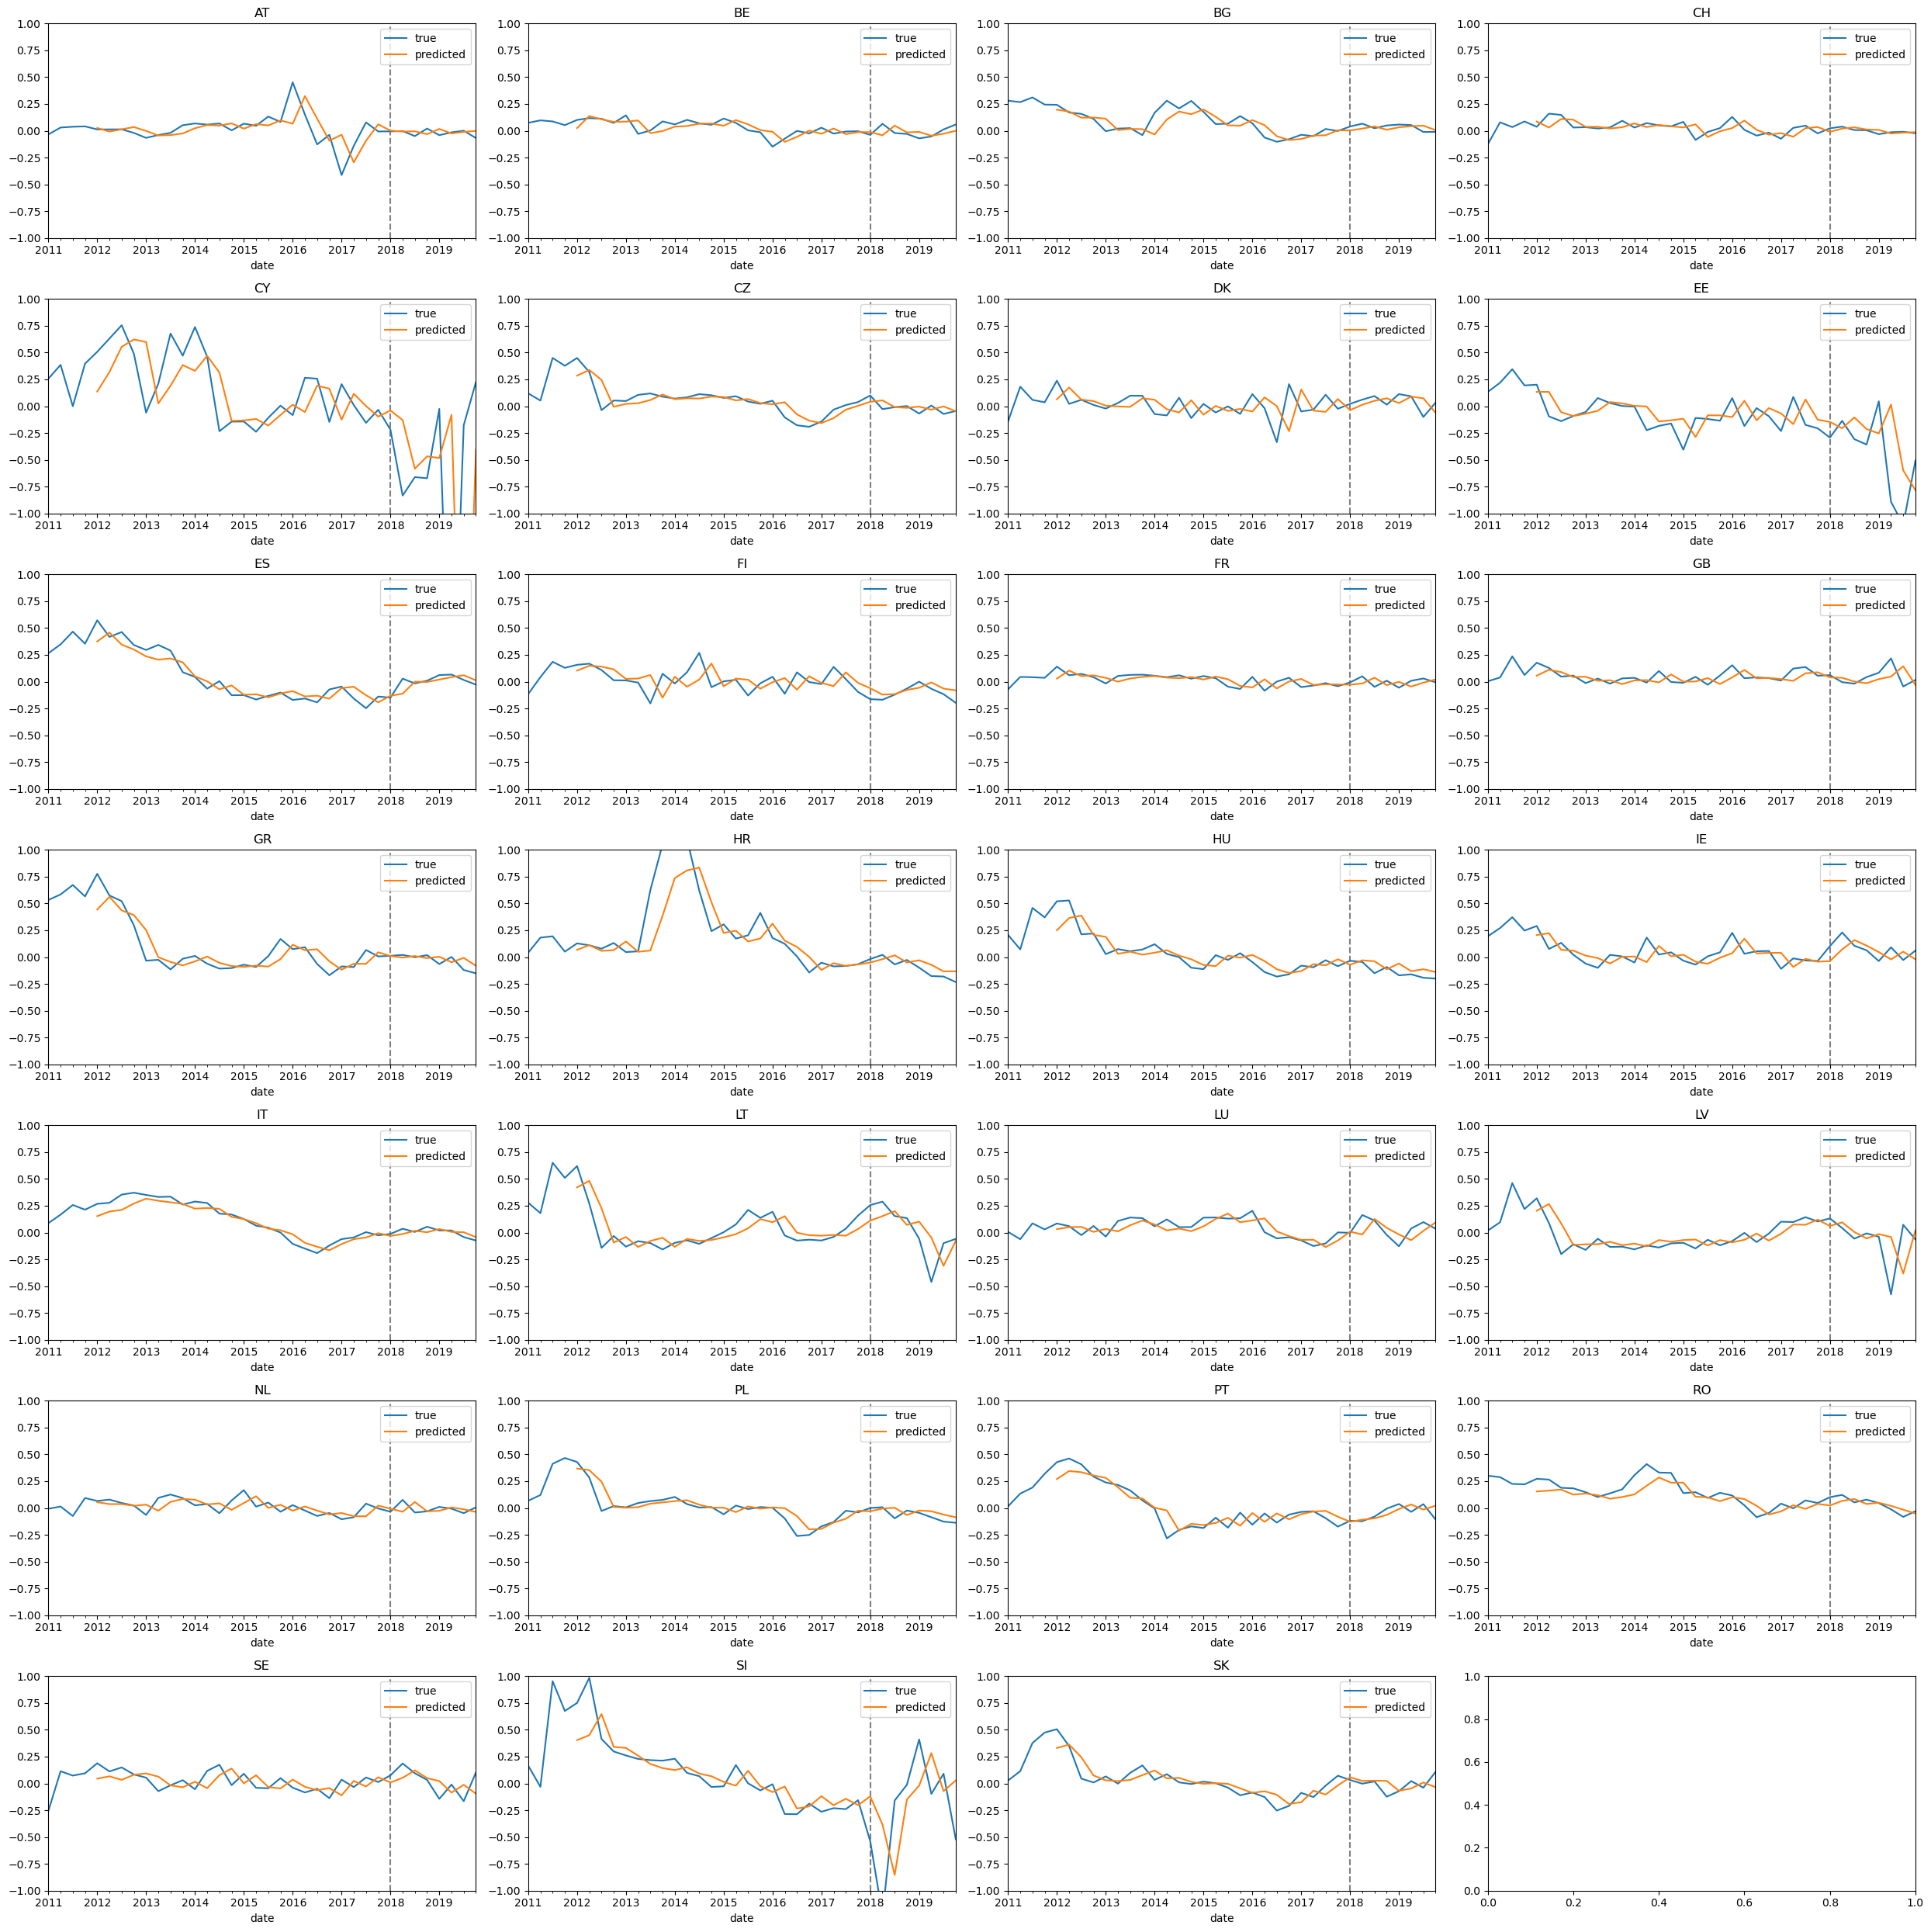

In [52]:
fig, axs = eval.plot_prediction(
    y_pred_all, y_trans, y_min=-1, y_max=1, t_min="2011", vline="2018", t_max="2019"
)
plt.show()


### LR - AR only

In [92]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[1, 2, 3, 4], columns=["value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(linear_model.LinearRegression())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'linearregression__fit_intercept': False, 'linearregression__positive': False}

Aggregate CV score:


,mean,std,sem
fit_time,0.003,4.417e-04,1.803e-04
score_time,0.004,2.938e-04,1.199e-04
test_mae,-0.080,1.607e-02,6.559e-03
test_rmse,-0.114,2.717e-02,1.109e-02
test_explained_variance,0.439,2.250e-01,9.186e-02
test_r2_mod,0.490,2.433e-01,9.931e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.004,0.004,-0.096,-0.131,0.654,0.807
1,0.003,0.004,-0.096,-0.151,0.342,0.363
2,0.003,0.003,-0.076,-0.115,0.712,0.738
3,0.003,0.004,-0.061,-0.080,0.523,0.510
4,0.003,0.003,-0.090,-0.122,0.164,0.186
5,0.002,0.004,-0.063,-0.086,0.239,0.333


Holdout score:


mae                  -0.130
rmse                 -0.382
explained_variance   -0.687
r2_mod               -0.613
dtype: float64

#### cv performance plot

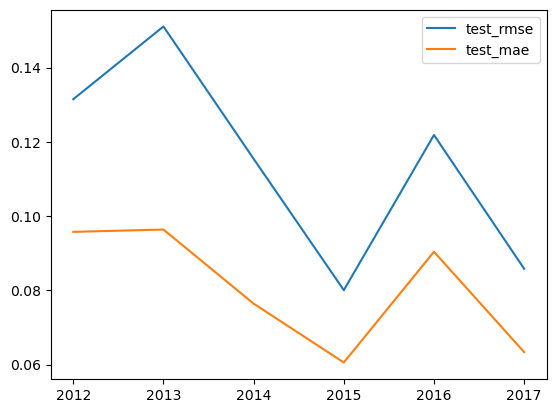

In [93]:
cv_score["test_rmse"].apply(lambda x: -x).plot()
cv_score["test_mae"].apply(lambda x: -x).plot()
# cv_score["test_r2_mod"].plot()
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5], [2012, 2013, 2014, 2015, 2016, 2017])
plt.show()

# save for comparison later
cv_score_without_trends = cv_score

### LR: AR + KW19 + aug

In [61]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.rolling("90D").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[3, 6, 9, 12], columns=["19", "value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(12))
y_trans = np.log(y) - np.log(y.shift(12))

test_dates = [
    "2018-01-01",
    "2018-04-01",
    "2018-07-01",
    "2018-10-01",
    "2019-01-01",
    "2019-04-01",
    "2019-07-01",
    "2019-10-01",
]

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans.loc[test_dates]
y_test = y_trans.loc[test_dates]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(linear_model.LinearRegression())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'linearregression__fit_intercept': True, 'linearregression__positive': False}

Aggregate CV score:


,mean,std,sem
fit_time,0.003,7.394e-04,3.018e-04
score_time,0.004,7.283e-04,2.973e-04
test_mae,-0.078,1.459e-02,5.958e-03
test_rmse,-0.111,2.697e-02,1.101e-02
test_explained_variance,0.463,1.570e-01,6.409e-02
test_r2_mod,0.509,1.968e-01,8.034e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.004,0.005,-0.090,-0.126,0.626,0.789
1,0.003,0.004,-0.091,-0.149,0.413,0.448
2,0.003,0.004,-0.081,-0.123,0.674,0.700
3,0.002,0.003,-0.061,-0.082,0.455,0.456
4,0.003,0.004,-0.085,-0.109,0.300,0.263
5,0.003,0.003,-0.058,-0.080,0.312,0.401


Holdout score:


mae                  -0.128
rmse                 -0.368
explained_variance   -0.555
r2_mod               -0.492
dtype: float64

#### predict

In [68]:
# y predicted over test set
pred_arr_test = reg.predict(x_test_stacked)
y_pred_stacked_test = pd.Series(pred_arr_test, index=x_test_stacked.index)
y_pred_trans_test = y_pred_stacked_test.unstack()

# y predicted over cv
pred_arr_cv = model_selection.cross_val_predict(reg, x_train_stacked, y_train_stacked, cv=cv)
y_pred_stacked_cv = pd.Series(pred_arr_cv, index=x_train_stacked.index)
y_pred_trans_cv = y_pred_stacked_cv.unstack()

y_pred_all = pd.concat([y_pred_trans_cv, y_pred_trans_test])


#### plot prediction (transformed)

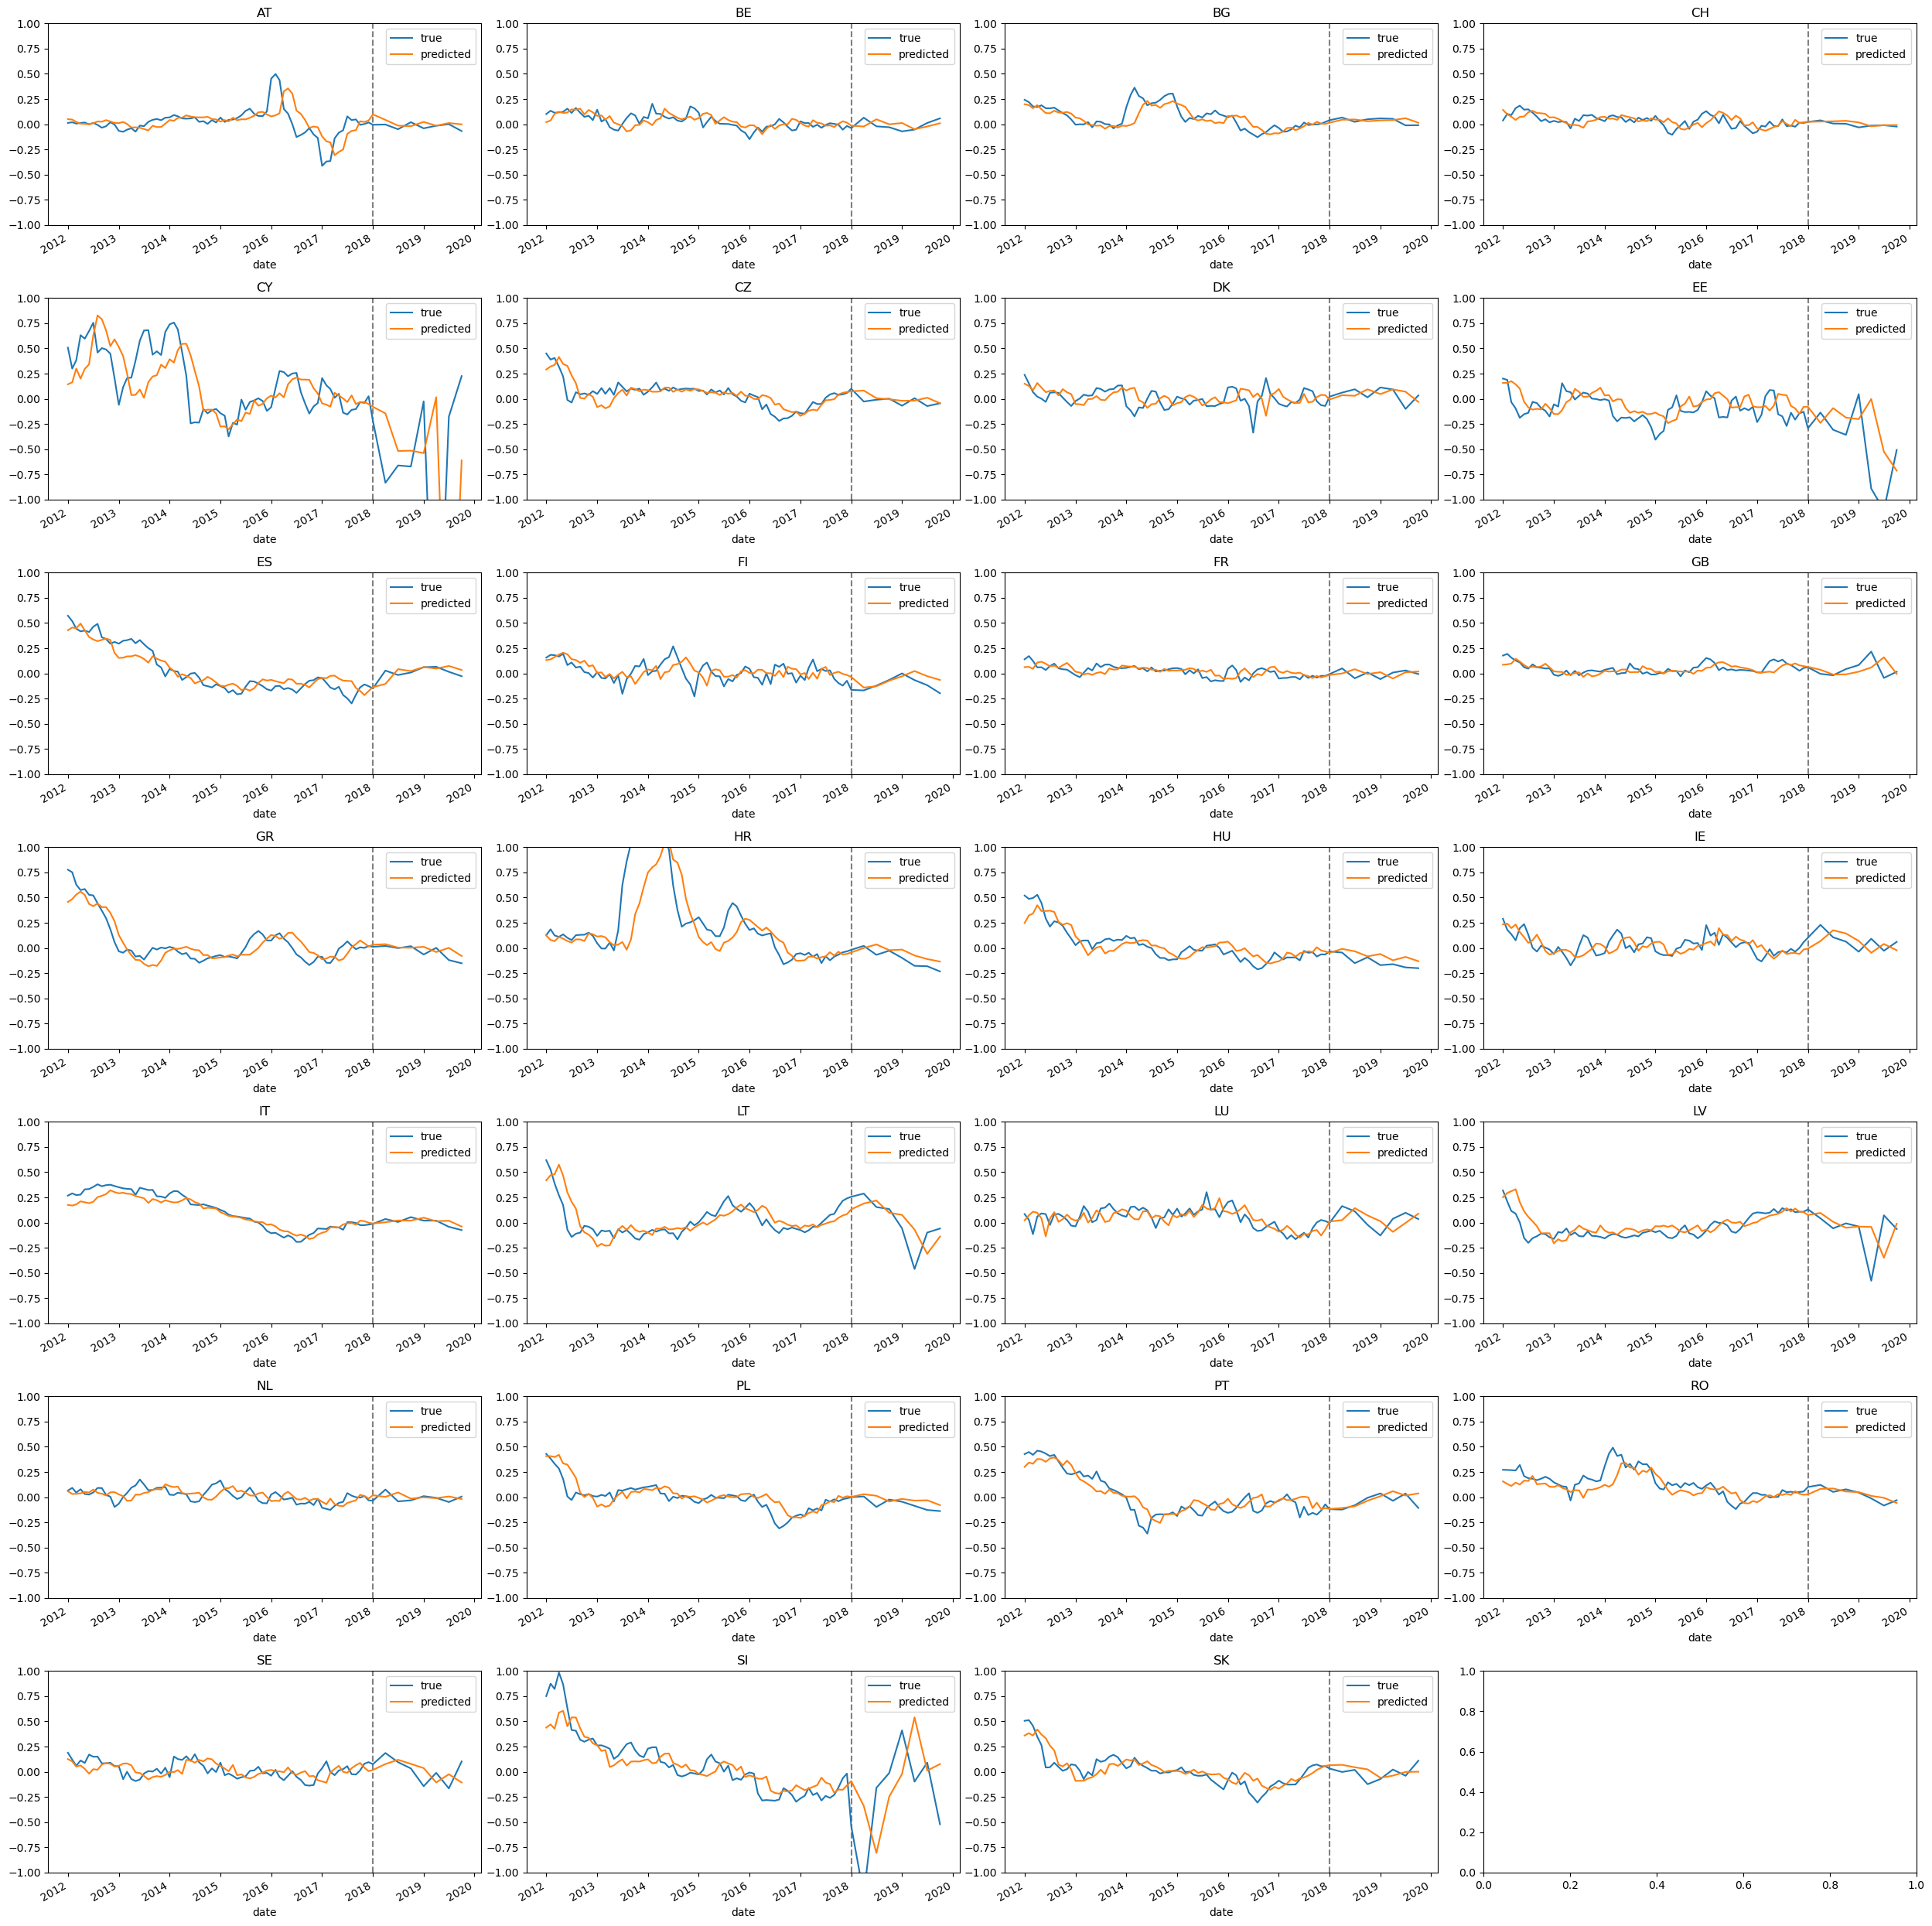

In [87]:
fig, axs = eval.plot_prediction(
    y_pred_all, y_trans, y_min=-1, y_max=1, t_min="2011", vline="2018", t_max="2019"
)
plt.show()


### LR: AR + aug

In [55]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.rolling("90D").mean()
panel_lags = data.create_lags(
    panel_resampled, lags=[3, 6, 9, 12], columns=["value"]
).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(12))
y_trans = np.log(y) - np.log(y.shift(12))

test_dates = [
    "2018-01-01",
    "2018-04-01",
    "2018-07-01",
    "2018-10-01",
    "2019-01-01",
    "2019-04-01",
    "2019-07-01",
    "2019-10-01",
]

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans.loc[test_dates]
y_test = y_trans.loc[test_dates]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(linear_model.LinearRegression())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)

cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)

test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'linearregression__fit_intercept': False, 'linearregression__positive': False}

Aggregate CV score:


,mean,std,sem
fit_time,0.003,1.442e-04,5.885e-05
score_time,0.004,4.976e-04,2.031e-04
test_mae,-0.077,1.313e-02,5.359e-03
test_rmse,-0.111,2.565e-02,1.047e-02
test_explained_variance,0.462,1.793e-01,7.321e-02
test_r2_mod,0.508,2.046e-01,8.352e-02


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.003,0.003,-0.086,-0.118,0.682,0.817
1,0.003,0.003,-0.090,-0.147,0.436,0.456
2,0.003,0.004,-0.080,-0.126,0.661,0.689
3,0.003,0.004,-0.062,-0.084,0.442,0.435
4,0.003,0.004,-0.083,-0.109,0.247,0.264
5,0.003,0.004,-0.059,-0.080,0.302,0.390


Holdout score:


mae                  -0.130
rmse                 -0.378
explained_variance   -0.649
r2_mod               -0.577
dtype: float64

### LR - all KWs

In [56]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(linear_model.LinearRegression())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'linearregression__fit_intercept': False, 'linearregression__positive': True}

Aggregate CV score:


,mean,std,sem
fit_time,0.028,0.008,0.003
score_time,0.012,0.008,0.003
test_mae,-0.085,0.016,0.006
test_rmse,-0.118,0.024,0.010
test_explained_variance,0.383,0.239,0.098
test_r2_mod,0.455,0.256,0.104


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.018,0.004,-0.109,-0.148,0.544,0.754
1,0.022,0.005,-0.080,-0.134,0.411,0.502
2,0.024,0.023,-0.088,-0.125,0.664,0.695
3,0.038,0.006,-0.065,-0.084,0.472,0.461
4,0.036,0.013,-0.093,-0.122,0.197,0.182
5,0.030,0.020,-0.071,-0.098,0.011,0.135


Holdout score:


mae                  -0.132
rmse                 -0.364
explained_variance   -0.527
r2_mod               -0.463
dtype: float64

#### feature importance

In [57]:
# features_names_out = reg.steps[0][1].get_feature_names_out(
#     reg.steps[0][1].get_feature_names_out()
# )
features_names_out = x_train_stacked.columns
pd.Series(reg.steps[0][1].coef_, index=features_names_out).sort_values(
    ascending=False
)

value_1    6.335e-01
115_1      5.693e-02
117_2      4.350e-02
123_1      3.753e-02
value_2    3.676e-02
39_4       3.121e-02
122_1      3.009e-02
28_1       2.853e-02
122_4      2.288e-02
16_3       2.028e-02
112_3      1.933e-02
19_3       1.906e-02
118_4      1.694e-02
112_1      1.630e-02
39_3       1.483e-02
39_1       1.432e-02
113_4      1.431e-02
21_2       1.385e-02
118_2      1.365e-02
58_3       1.336e-02
57_2       1.180e-02
11_4       1.100e-02
117_3      1.098e-02
37_3       1.064e-02
37_4       1.058e-02
10_4       1.043e-02
32_3       1.038e-02
26_3       1.006e-02
48_4       8.938e-03
59_1       8.400e-03
54_3       8.189e-03
58_1       7.754e-03
12_1       7.511e-03
49_4       7.355e-03
33_3       7.071e-03
20_1       6.588e-03
115_3      6.517e-03
19_1       6.259e-03
58_4       5.529e-03
60_1       5.002e-03
18_1       4.649e-03
24_1       4.570e-03
26_1       4.309e-03
42_2       3.514e-03
49_1       3.381e-03
19_2       3.233e-03
42_1       3.113e-03
20_4       3.

### Lasso - all KWs

In [58]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.Lasso())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "lasso__alpha": [1.0, 0.2, 0.1, 0.5, 0.01],
        "lasso__fit_intercept": [True, False],
        "lasso__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'lasso__alpha': 0.01, 'lasso__fit_intercept': True, 'lasso__positive': True}

Aggregate CV score:


,mean,std,sem
fit_time,0.011,0.003,1.176e-03
score_time,0.007,0.001,6.030e-04
test_mae,-0.080,0.017,6.751e-03
test_rmse,-0.116,0.026,1.072e-02
test_explained_variance,0.415,0.235,9.606e-02
test_r2_mod,0.478,0.250,1.019e-01


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.011,0.007,-0.104,-0.146,0.606,0.762
1,0.010,0.006,-0.077,-0.136,0.392,0.483
2,0.007,0.008,-0.081,-0.123,0.674,0.705
3,0.010,0.009,-0.059,-0.077,0.543,0.547
4,0.013,0.007,-0.094,-0.124,0.172,0.155
5,0.016,0.005,-0.068,-0.093,0.103,0.214


Holdout score:


mae                  -0.126
rmse                 -0.367
explained_variance   -0.549
r2_mod               -0.485
dtype: float64

#### feature importance

In [60]:
# features_names_out = reg.steps[0][1].get_feature_names_out(
#     reg.steps[0][1].get_feature_names_out()
# )
features_names_out = x_train_stacked.columns
pd.Series(reg.steps[1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)

value_1    1.252e-01
19_3       8.552e-03
115_1      5.953e-03
21_2       4.999e-03
28_1       4.568e-03
value_2    4.223e-03
19_1       4.206e-03
112_3      2.709e-03
117_2      1.699e-03
48_4       9.060e-04
11_4       6.229e-04
12_1       4.460e-04
2_4        0.000e+00
42_1       0.000e+00
28_3       0.000e+00
39_2       0.000e+00
39_3       0.000e+00
39_4       0.000e+00
41_1       0.000e+00
41_2       0.000e+00
41_3       0.000e+00
41_4       0.000e+00
42_2       0.000e+00
32_1       0.000e+00
42_3       0.000e+00
42_4       0.000e+00
43_1       0.000e+00
43_2       0.000e+00
28_2       0.000e+00
43_3       0.000e+00
43_4       0.000e+00
44_1       0.000e+00
39_1       0.000e+00
38_4       0.000e+00
38_3       0.000e+00
38_2       0.000e+00
32_2       0.000e+00
32_3       0.000e+00
2_3        0.000e+00
2_2        0.000e+00
32_4       0.000e+00
33_1       0.000e+00
33_2       0.000e+00
2_1        0.000e+00
33_3       0.000e+00
33_4       0.000e+00
37_1       0.000e+00
28_4       0.

In [43]:
t_min = "2012-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

panel_resampled = panel.resample("3M").mean()
panel_lags = data.create_lags(panel_resampled, lags=[1, 2, 3, 4]).fillna(0.0)

# define x, y; set minimum value
x = panel_lags.applymap(lambda x: max(x, 0.1))
y = panel_resampled["value"].applymap(lambda x: max(x, 1.0))

# transformation: logdiff
x_trans = np.log(x) - np.log(x.shift(4))
y_trans = np.log(y) - np.log(y.shift(4))

x_train = x_trans[t_min:t_split_lower]
y_train = y_trans[t_min:t_split_lower]
x_test = x_trans[t_split_upper:t_max]
y_test = y_trans[t_split_upper:t_max]

# stacking
x_train_stacked, y_train_stacked = data.stack(x_train, y_train, extra_column=False)
x_test_stacked, y_test_stacked = data.stack(x_test, y_test, extra_column=False)

cv = model_selection.KFold(n_splits=6, shuffle=False)

# ct = compose.make_column_transformer(
#     (preprocessing.OneHotEncoder(), ["country"]),
#     remainder="passthrough",
#     sparse_threshold=0,
# )

# reg = pipeline.make_pipeline(ct, linear_model.LinearRegression())
reg = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.ElasticNet())

hptuner = model_selection.GridSearchCV(
    reg,
    {
        "elasticnet__alpha": [1.0, 0.2, 0.1, 0.5, 0.01],
        "elasticnet__l1_ratio": [0.4, 0.45, 0.5, 0.55, 0.6],
        "elasticnet__fit_intercept": [True, False],
        "elasticnet__positive": [True, False],
    },
    cv=cv,
    scoring=eval.scorer_rmse,
    n_jobs=-1,
)
hptuner.fit(x_train_stacked, y_train_stacked)
reg = hptuner.best_estimator_
display(hptuner.best_params_)


cv_score = eval.score_cv(reg, x_train_stacked, y_train_stacked, cv=cv)
test_score = eval.score_test(reg, x_test_stacked, y_test_stacked)

print("Aggregate CV score:")
display(eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


{'elasticnet__alpha': 0.01,
 'elasticnet__fit_intercept': True,
 'elasticnet__l1_ratio': 0.45,
 'elasticnet__positive': True}

Aggregate CV score:


,mean,std,sem
fit_time,0.012,0.002,9.480e-04
score_time,0.006,0.001,5.490e-04
test_mae,-0.080,0.016,6.511e-03
test_rmse,-0.116,0.026,1.069e-02
test_explained_variance,0.417,0.233,9.502e-02
test_r2_mod,0.481,0.246,1.004e-01


Individual CV scores:


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod
0,0.010,0.005,-0.103,-0.146,0.592,0.761
1,0.011,0.006,-0.077,-0.136,0.397,0.482
2,0.012,0.007,-0.080,-0.122,0.679,0.709
3,0.010,0.007,-0.058,-0.077,0.548,0.551
4,0.016,0.007,-0.092,-0.122,0.200,0.180
5,0.012,0.004,-0.068,-0.094,0.090,0.205


Holdout score:


mae                  -0.128
rmse                 -0.364
explained_variance   -0.524
r2_mod               -0.461
dtype: float64

## Analysis

### Compare CV performance with/without trends

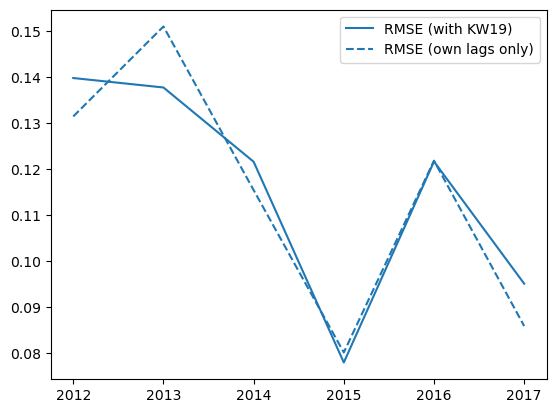

In [94]:
cv_score_with_trends["test_rmse"].apply(lambda x: -x).plot(label="RMSE (with KW19)", color="tab:blue")
cv_score_without_trends["test_rmse"].apply(lambda x: -x).plot(label="RMSE (own lags only)", linestyle="dashed", color="tab:blue")
# cv_score["test_r2_mod"].plot()
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5], [2012, 2013, 2014, 2015, 2016, 2017])
plt.show()
